In [1]:
from centrex_tlf import states, couplings, transitions, lindblad, utils, hamiltonian
import numpy as np
from labellines import labelLine, labelLines
import matplotlib.pyplot as plt

from centrex_tlf_julia_extension import lindblad_julia

c:\Users\Olivier\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\Lib\site-packages\juliacall\__init__.py:271: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
P2 = transitions.OpticalTransition(transitions.OpticalTransitionType.P, 2, 3 / 2, 1)
J12 = transitions.MicrowaveTransition(1, 2)
J23 = transitions.MicrowaveTransition(2, 3)
transition_selectors = couplings.generate_transition_selectors(
    [P2, J12, J23],
    [
        [couplings.polarization_Z],
        [
            (couplings.polarization_X - couplings.polarization_Z).normalize(),
            couplings.polarization_Y,
        ],
        [
            (couplings.polarization_X + couplings.polarization_Z).normalize(),
            couplings.polarization_Y,
        ],
    ],
)
system = lindblad.generate_OBE_system_transitions([P2, J12, J23], transition_selectors)

In [4]:
[trans.polarization_symbols for trans in transition_selectors]

[[PZ0], [PA1, PY1], [PA2, PY2]]

In [ ]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    Ω1=hamiltonian.Γ,
    Ω2=hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    δ1=0.0,
    δ2=0.0,
    PZ0=1.0,
    PJ12="square_wave(t, ω12, 0.0)",
    PJ23="square_wave(t, ω23, ϕ)",
    PA1="PJ12",
    PY1="1-PJ12",
    PA2="PJ23",
    PY2="1-PJ23",
    ω12=2 * np.pi * 1e6,
    ω23=2 * np.pi * 1e6,
    ϕ=np.pi / 2,
)

In [6]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    system, transition_selectors, odepars, n_procs=6
)

In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F1 = 3/2, F = 1>"
states,
"|X, J = 0>",0.484124
"|X, J = 2>",0.515876


In [ ]:
ρ = utils.population.generate_thermal_population_states(6.3, obe_system.QN)

In [9]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [10]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [11]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)

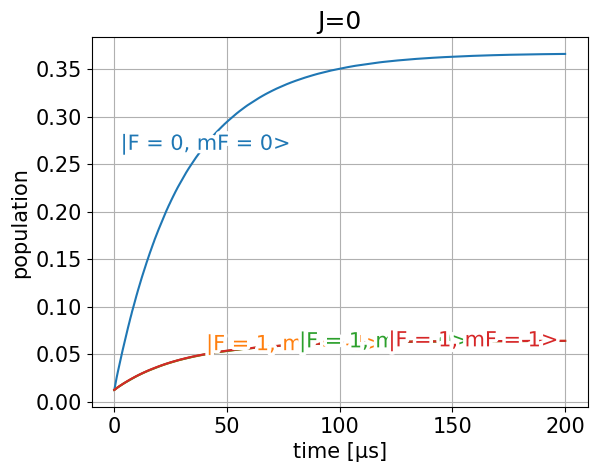

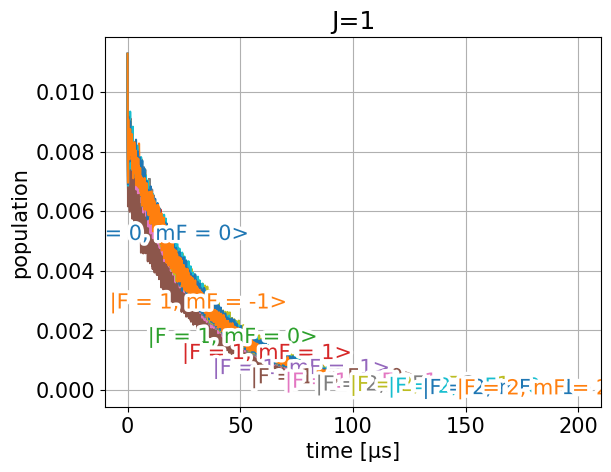

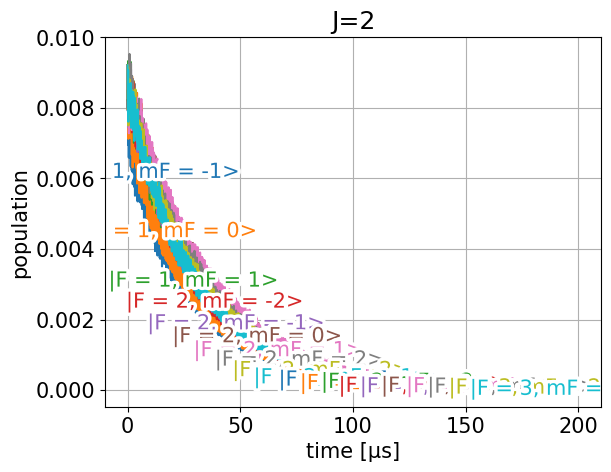

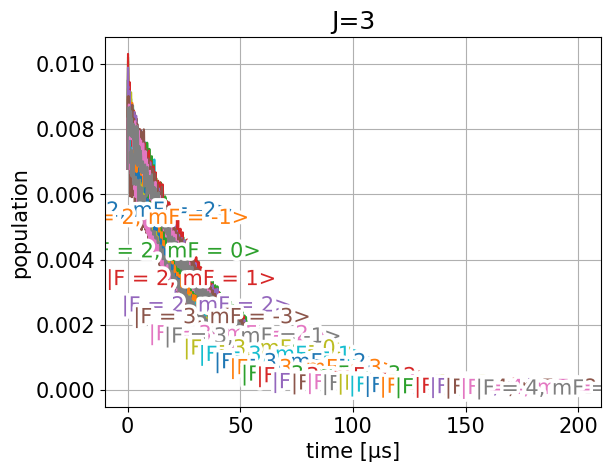

In [12]:
for J, ind in enumerate([indices_J0, indices_J1, indices_J2, indices_J3]):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()

In [13]:
from centrex_tlf_julia_extension.lindblad_julia.utils_julia import jl

julia_packages = ["BenchmarkTools"]
jl.seval("using Pkg")
for pkg in julia_packages:
    if not bool(jl.seval(f'isnothing(Base.find_package("{pkg}")) ? false : true')):
        print(f"Installing Julia package: {pkg}")
        jl.Pkg.add(pkg)
jl.seval("using BenchmarkTools")

In [14]:
_ = jl.seval("du = similar(ρ)")
_ = jl.seval("t = 0.0")

In [15]:
jl.seval("@benchmark Lindblad_rhs!(du, ρ, p, t)")

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  101.900 μs … 462.800 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     116.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   125.187 μs ±  29.225 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄█▇▅▄▃▂▂▁  ▂█▆▄▃▁▁     ▁                             ▁▁       ▂
  ██████████▇███████▇█▇███▇▆▆██▆▆▅▆▅▆▄▅█▇▄▅▃▃▂▄▄▄▇▇▇▇▆▇███▇▇▆▅▅ █
  102 μs        Histogram: log(frequency) by time        239 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [ ]:
solve_str = lindblad_julia.utils_solver._generate_problem_solve_string(
    problem, config
).replace("\n", "")

In [17]:
jl.seval(f"@benchmark {solve_str} samples=10 evals=1 seconds=120")

BenchmarkTools.Trial: 10 samples with 1 evaluation per sample.
 Range (min … max):  7.946 s …    9.015 s  ┊ GC (min … max): 0.04% … 10.83%
 Time  (median):     8.482 s               ┊ GC (median):    3.52%
 Time  (mean ± σ):   8.499 s ± 315.972 ms  ┊ GC (mean ± σ):  3.88% ±  3.37%

                        █                                     
  ▇▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▇▇▁▁▇▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▇ ▁
  7.95 s         Histogram: frequency by time         9.01 s <

 Memory estimate: 574.53 MiB, allocs estimate: 25167.

# Matrix Method

In [18]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars, n_procs=6, method="matrix"
)

In [19]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [20]:
results = lindblad_julia.do_simulation_single(problem, config=config)

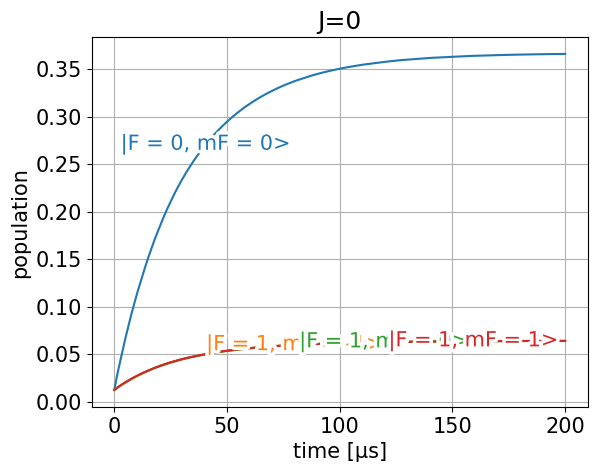

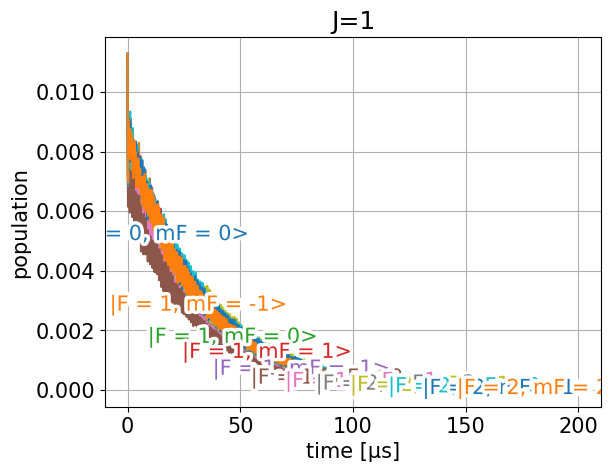

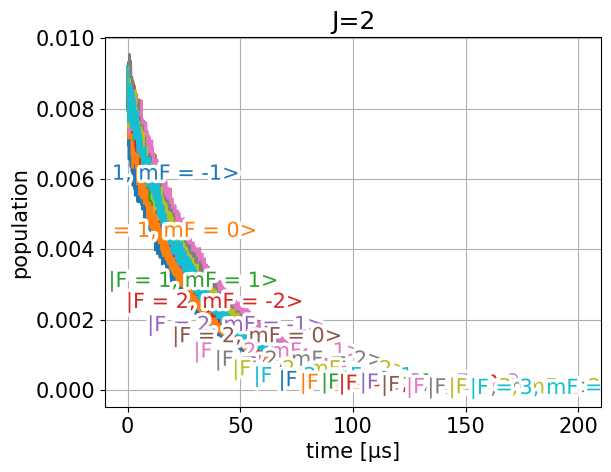

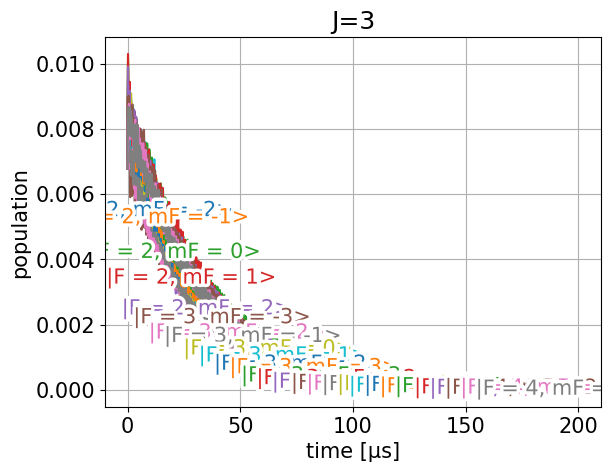

In [21]:
for J, ind in enumerate([indices_J0, indices_J1, indices_J2, indices_J3]):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()

In [22]:
jl.seval("@benchmark Lindblad_rhs!(du, ρ, p, t)")

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  52.600 μs … 562.100 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     68.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   68.849 μs ±  14.749 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                     ▄██▄▁                                      
  ▁▂▂▂▁▁▂▂▂▄▄▅▅██▇▅▅▆█████▆▆▆▅▄▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  52.6 μs         Histogram: frequency by time         97.6 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [ ]:
solve_str = lindblad_julia.utils_solver._generate_problem_solve_string(
    problem, config
).replace("\n", "")

In [24]:
jl.seval(f"@benchmark {solve_str} samples=10 evals=1 seconds=120")

BenchmarkTools.Trial: 10 samples with 1 evaluation per sample.
 Range (min … max):  5.359 s …    6.702 s  ┊ GC (min … max): 0.06% … 17.52%
 Time  (median):     5.842 s               ┊ GC (median):    1.35%
 Time  (mean ± σ):   5.885 s ± 466.567 ms  ┊ GC (mean ± σ):  4.15% ±  5.75%

  █ █ █  █           █  █    █         █          █        █  
  █▁█▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█ ▁
  5.36 s         Histogram: frequency by time          6.7 s <

 Memory estimate: 611.19 MiB, allocs estimate: 26755.